In [7]:
%load_ext autoreload
%autoreload 2
import spikeinterface.full as si
from probeinterface.plotting import plot_probe, plot_probegroup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import gridspec
from scipy import stats
import os
from Helpers import plot_utility
from astropy.nddata import block_reduce
import matplotlib.ticker as ticker
from Helpers.plot_utility import pandas_collumn_to_2d_numpy_array, pandas_collumn_to_numpy_array
from P3_CurrentAnalysis.basic_lomb_scargle_estimator import lomb_scargle_parallel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:

def plot_firing_rate_maps_per_trial_2(cluster_spike_data, track_length, save_path=None, ax=None):
    firing_times_cluster = cluster_spike_data["firing_times_vr"].iloc[0]
    if len(firing_times_cluster)>1:
        cluster_firing_maps = np.array(cluster_spike_data['fr_binned_in_space_smoothed'].iloc[0])
        cluster_firing_maps[np.isnan(cluster_firing_maps)] = 0
        cluster_firing_maps[np.isinf(cluster_firing_maps)] = 0
        percentile_99th_display = np.nanpercentile(cluster_firing_maps, 95)
        cluster_firing_maps = min_max_normalize(cluster_firing_maps)
        percentile_99th = np.nanpercentile(cluster_firing_maps, 95)
        cluster_firing_maps = np.clip(cluster_firing_maps, a_min=0, a_max=percentile_99th)
        vmin, vmax = get_vmin_vmax(cluster_firing_maps)

        locations = np.arange(0, len(cluster_firing_maps[0]))
        ordered = np.arange(0, len(cluster_firing_maps), 1)
        X, Y = np.meshgrid(locations, ordered)
        if ax is None:
            fig = plt.figure()
            fig.set_size_inches(5, 5, forward=True)
            ax = fig.add_subplot(1, 1, 1)

        ax.pcolormesh(X, Y, cluster_firing_maps, shading="auto", vmin=vmin, vmax=vmax)
        ax.set_title(str(np.round(percentile_99th_display, decimals=1))+" Hz", fontsize=20)
        ax.set_ylabel('Trial Number', fontsize=20, labelpad = 20)
        ax.set_xlabel('Location (cm)', fontsize=20, labelpad = 20)
        ax.set_xlim([0, track_length])
        ax.set_ylim([0, len(cluster_firing_maps)-1])
        ax.tick_params(axis='both', which='both', labelsize=20)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        tick_spacing = 100
        ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        #cbar = spikes_on_track.colorbar(c, ax=ax, fraction=0.046, pad=0.04)
        #cbar.set_label('Firing Rate (Hz)', rotation=270, fontsize=20)
        #cbar.set_ticks([0,np.max(cluster_firing_maps)])
        #cbar.set_ticklabels(["0", "Max"])
        #cbar.ax.tick_params(labelsize=20)
        plt.subplots_adjust(hspace = .35, wspace = .35,  bottom = 0.2, left = 0.3, right = 0.87, top = 0.92)
        if save_path is not None:
            plt.savefig(save_path + '/firing_rate_map_trials_' + 
                        spike_data.session_id.iloc[cluster_index] + '_' + 
                        str(int(cluster_id)) + '.png', dpi=300) 

In [9]:
def plot_firing_rate_maps_short(cluster_data, track_length=200, ax=None, save_path=None):
    firing_times_cluster = cluster_data["firing_times_vr"].iloc[0]
    cluster_id = cluster_data["cluster_id"].iloc[0]

    if len(firing_times_cluster)>1:
        cluster_firing_maps = np.array(cluster_data['fr_binned_in_space_smoothed'].iloc[0])
        cluster_firing_maps[np.isnan(cluster_firing_maps)] = np.nan
        cluster_firing_maps[np.isinf(cluster_firing_maps)] = np.nan

        if ax is None: 
            spikes_on_track = plt.figure()
            spikes_on_track.set_size_inches(5, 5/3, forward=True)
            ax = spikes_on_track.add_subplot(1, 1, 1)
        
        locations = np.arange(0, len(cluster_firing_maps[0]))
        ax.fill_between(locations, np.nanmean(cluster_firing_maps, axis=0) - stats.sem(cluster_firing_maps, axis=0,nan_policy="omit"),
                                    np.nanmean(cluster_firing_maps, axis=0) + stats.sem(cluster_firing_maps, axis=0,nan_policy="omit"), color="black", alpha=0.2)
        ax.plot(locations, np.nanmean(cluster_firing_maps, axis=0), color="black", linewidth=1)
        
        #plt.ylabel('FR (Hz)', fontsize=25, labelpad = 10)
        #plt.xlabel('Location (cm)', fontsize=25, labelpad = 10)
        plt.xlim(0, track_length)
        ax.tick_params(axis='both', which='both', labelsize=20)
        ax.set_xlim([0, track_length])
        max_fr = max(np.nanmean(cluster_firing_maps, axis=0)+stats.sem(cluster_firing_maps, axis=0))
        max_fr = max_fr+(0.1*(max_fr))
        #ax.set_ylim([0, max_fr])
        ax.set_yticks([0, np.round(ax.get_ylim()[1], 1)])
        ax.set_ylim(bottom=0)
        plot_utility.style_track_plot(ax, track_length, alpha=0.15)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        plt.subplots_adjust(hspace = .35, wspace = .35,  bottom = 0.2, left = 0.3, right = 0.87, top = 0.92)
        if save_path is not None:
            plt.savefig(save_path + '/avg_firing_rate_maps_short_' + cluster_data.session_id.iloc[0] + '_' + str(int(cluster_id)) + '.png', dpi=300)              

In [10]:
def min_max_normalize(x):
    """
        argument
            - x: input image data in numpy array [32, 32, 3]
        return
            - normalized x
    """
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-min_val) / (max_val-min_val)
    return x

In [11]:
def get_vmin_vmax(cluster_firing_maps, bin_cm=8):
    cluster_firing_maps_reduced = []
    for i in range(len(cluster_firing_maps)):
        cluster_firing_maps_reduced.append(block_reduce(cluster_firing_maps[i], bin_cm, func=np.mean))
    cluster_firing_maps_reduced = np.array(cluster_firing_maps_reduced)
    vmin= 0
    vmax= np.max(cluster_firing_maps_reduced)
    return vmin, vmax

In [12]:
def ramp_score(ramp_data_vr):
    ramp_data_vr = ramp_data_vr.fillna('None') # replace None types with None strings for ease
    df = pd.DataFrame()
    for cluster_id in np.unique(ramp_data_vr["cluster_id"]):

        outbound = ramp_data_vr[(ramp_data_vr["cluster_id"] == cluster_id) &
                                (ramp_data_vr["trial_type"] == "None") &
                                (ramp_data_vr["hit_miss_try"] == "None") &
                                (ramp_data_vr["track_length"] == "outbound")]["ramp_class"].iloc[0]
        homebound = ramp_data_vr[(ramp_data_vr["cluster_id"] == cluster_id) &
                                 (ramp_data_vr["trial_type"] == "None") &
                                 (ramp_data_vr["hit_miss_try"] == "None") &
                                 (ramp_data_vr["track_length"] == "homebound")]["ramp_class"].iloc[0]
        ramp_class = outbound+homebound
        cluster_df = pd.DataFrame({'cluster_id': [cluster_id],
                                   'outbound_homebound_ramp_class': [ramp_class]})
        df = pd.concat([df, cluster_df], ignore_index=True)
    return df


In [17]:
def calculate_spatial_information(spatial_firing, position_data, track_length):
    position_heatmap = np.zeros(track_length)
    for x in np.arange(track_length):
        bin_occupancy = len(position_data[(position_data["x_position_cm"] > x) &
                                                (position_data["x_position_cm"] <= x+1)])
        position_heatmap[x] = bin_occupancy
    position_heatmap = position_heatmap*np.diff(position_data["time_seconds"])[-1] # convert to real time in seconds
    occupancy_probability_map = position_heatmap/np.sum(position_heatmap) # Pj

    spatial_information_scores_Ispike = []
    spatial_information_scores_Isec = []
    for cluster_index, cluster_id in enumerate(spatial_firing.cluster_id):
        cluster_df = spatial_firing[(spatial_firing.cluster_id == cluster_id)] # dataframe for that cluster

        mean_firing_rate = len(cluster_df.iloc[0]["firing_times"])/np.sum(len(position_data)*np.diff(position_data["time_seconds"])[-1]) # λ
        spikes, _ = np.histogram(np.array(cluster_df['x_position_cm'].iloc[0]), bins=track_length, range=(0,track_length))
        rates = spikes/position_heatmap

        Isec, Ispike = spatial_info(mean_firing_rate, occupancy_probability_map, rates)

        spatial_information_scores_Ispike.append(Ispike)
        spatial_information_scores_Isec.append(Isec)

    spatial_firing["spatial_information_score_Isec"] = spatial_information_scores_Isec
    spatial_firing["spatial_information_score_Ispike"] = spatial_information_scores_Ispike
    return spatial_firing

def spatial_info(mrate, occupancy_probability_map, rates):
    Isec = np.sum(occupancy_probability_map * rates * np.log2((rates / mrate) + 0.0001))
    Ispike = Isec / mrate
    return Isec, Ispike


In [14]:

def plot_network_anchor(spike_data, position_data):
    filtered_df = pd.DataFrame()
    for i, cluster_df in spike_data.iterrows():
        cluster_df = cluster_df.to_frame().T.reset_index(drop=True)
        if isinstance(cluster_df['ls_deltas'].iloc[0], np.ndarray):
            filtered_df = pd.concat([filtered_df, cluster_df], ignore_index=True)

    filtered_df = calculate_spatial_information(filtered_df, position_data, track_length=200)
    filtered_df = filtered_df.sort_values(by=["shank_id_x", "spatial_information_score_Isec"], ascending=False)

    data = pandas_collumn_to_2d_numpy_array(filtered_df["ls_deltas"])
    print(np.shape(data))
    
    plt.imshow(data, cmap='viridis', aspect='auto')
    plt.colorbar(label='ls delta')
    plt.show()
    plt.plot(np.arange(len(data[0])), np.nanmean(data, axis=0))
    plt.show()

## M21 ramp cells

In [ ]:
project_path = "/mnt/datastore/Harry/Cohort11_april2024/derivatives/"
# get sorting analyzer and unit locations
of_session_base_names = ["M21_D26_2024-05-28_16-35-31_OF1", "M21_D23_2024-05-25_16-07-17_OF1", "M21_D25_2024-05-27_15-35-57_OF1", "M21_D24_2024-05-26_15-58-23_OF1"]
vr_session_base_names = ["M21_D26_2024-05-28_17-04-41_VR1", "M21_D23_2024-05-25_16-54-12_VR1", "M21_D25_2024-05-27_16-00-30_VR1", "M21_D24_2024-05-26_16-35-19_VR1"]
 
M21_master_data = pd.DataFrame()
for vr_name, of_name in zip(vr_session_base_names, of_session_base_names):
    mouse = vr_name.split("_")[0]
    day = vr_name.split("_")[1]
    sorting_analyzer_path = f"{project_path}{mouse}/{day}/ephys/sorting_analyzer"
    vr_path = f"{project_path}{mouse}/{day}/vr/{vr_name}/processed/kilosort4/spikes.pkl"
    ramp_path = f"{project_path}{mouse}/{day}/vr/{vr_name}/processed/kilosort4/ramp_classifications.pkl"
    of_path = f"{project_path}{mouse}/{day}/of/{of_name}/processed/kilosort4/spikes.pkl"

    spike_data_vr = pd.read_pickle(vr_path); spike_data_vr["firing_times_vr"] = spike_data_vr["firing_times"]; spike_data_vr["session_id_vr"] = vr_name
    spike_data_of = pd.read_pickle(of_path); spike_data_of["firing_times_of"] = spike_data_of["firing_times"]; spike_data_of["session_id_of"] = of_name
    ramp_data_vr = pd.read_pickle(ramp_path)
    ramp_data_vr = ramp_score(ramp_data_vr)
    spike_data = pd.merge(spike_data_vr, spike_data_of, on="cluster_id")
    spike_data = pd.merge(spike_data, ramp_data_vr, on="cluster_id")
    M21_master_data = pd.concat([M21_master_data, spike_data])

### curate
print(f"pre-curation M21: {len(M21_master_data)}")
M21_master_data = M21_master_data[(M21_master_data["snr_x"] > 1) & (M21_master_data["mean_firing_rate_x"] > 0.5) & (M21_master_data["rp_contamination_x"] < 0.9)]
print(f"post-curation M21: {len(M21_master_data)}")



In [ ]:
subset = M21_master_data[M21_master_data['grid_score'] > 0.7]
for i, cluster_df in subset.iterrows():
    cluster_df = cluster_df.to_frame().T.reset_index(drop=True)
    cluster_id = cluster_df["cluster_id"].iloc[0]
    grid_score = cluster_df["grid_score"].iloc[0]
    session_id_vr = cluster_df["session_id_vr"].iloc[0]

    fig, ax = plt.subplots(figsize=(4, 4)) 
    plot_firing_rate_maps_per_trial_2(cluster_df, track_length=200, ax=ax, save_path=None)
    plt.savefig(f"/mnt/datastore/Harry/plot_viewer/grid_maps/c{cluster_id}_long_{session_id_vr}.png", dpi=100)
    plt.close()
    fig, ax = plt.subplots(figsize=(4, 2)) 
    plot_firing_rate_maps_short(cluster_df, track_length=200, ax=ax, save_path=None)
    ax.set_title(f"GS: {np.round(grid_score, decimals=2)}")
    plt.savefig(f"/mnt/datastore/Harry/plot_viewer/grid_maps/c{cluster_id}_short_{session_id_vr}.png", dpi=100)
    plt.close()
    plt.close('all')

print()
 
        
        

In [ ]:
project_path = "/mnt/datastore/Harry/Cohort11_april2024/derivatives/"
# get sorting analyzer and unit locations
of_session_base_names = ["M21_D26_2024-05-28_16-35-31_OF1"]
vr_session_base_names = ["M21_D26_2024-05-28_17-04-41_VR1"]
 
M21_D26_master_data = pd.DataFrame()
for vr_name, of_name in zip(vr_session_base_names, of_session_base_names):
    mouse = vr_name.split("_")[0]
    day = vr_name.split("_")[1]
    sorting_analyzer_path = f"{project_path}{mouse}/{day}/ephys/sorting_analyzer"
    vr_path = f"{project_path}{mouse}/{day}/vr/{vr_name}/processed/kilosort4/spikes.pkl"
    ramp_path = f"{project_path}{mouse}/{day}/vr/{vr_name}/processed/kilosort4/ramp_classifications.pkl"
    of_path = f"{project_path}{mouse}/{day}/of/{of_name}/processed/kilosort4/spikes.pkl"

    spike_data_vr = pd.read_pickle(vr_path); spike_data_vr["firing_times_vr"] = spike_data_vr["firing_times"]; spike_data_vr["session_id_vr"] = vr_name
    spike_data_of = pd.read_pickle(of_path); spike_data_of["firing_times_of"] = spike_data_of["firing_times"]; spike_data_of["session_id_of"] = of_name
    ramp_data_vr = pd.read_pickle(ramp_path)
    ramp_data_vr = ramp_score(ramp_data_vr)
    spike_data = pd.merge(spike_data_vr, spike_data_of, on="cluster_id")
    spike_data = pd.merge(spike_data, ramp_data_vr, on="cluster_id")
    M21_D26_master_data = pd.concat([M21_D26_master_data, spike_data])

### curate
print(f"pre-curation M21: {len(M21_D26_master_data)}")
M21_D26_master_data = M21_D26_master_data[(M21_D26_master_data["snr_x"] > 1) & (M21_D26_master_data["mean_firing_rate_x"] > 0.5) & (M21_D26_master_data["rp_contamination_x"] < 0.9)]
print(f"post-curation M21: {len(M21_D26_master_data)}")
position_path = f"{project_path}{mouse}/{day}/vr/{vr_name}/processed/position_data.pkl"
position_data = pd.read_pickle(position_path)

In [ ]:
project_path = "/mnt/datastore/Harry/Cohort11_april2024/derivatives/"
# get sorting analyzer and unit locations
of_session_base_names = ["M21_D26_2024-05-28_16-35-31_OF1", "M21_D23_2024-05-25_16-07-17_OF1", "M21_D25_2024-05-27_15-35-57_OF1", "M21_D24_2024-05-26_15-58-23_OF1"]
vr_session_base_names = ["M21_D26_2024-05-28_17-04-41_VR1", "M21_D23_2024-05-25_16-54-12_VR1", "M21_D25_2024-05-27_16-00-30_VR1", "M21_D24_2024-05-26_16-35-19_VR1"]
 

for vr_name, of_name in zip(vr_session_base_names, of_session_base_names):
    mouse = vr_name.split("_")[0]
    day = vr_name.split("_")[1]
    sorting_analyzer_path = f"{project_path}{mouse}/{day}/ephys/sorting_analyzer"
    vr_path = f"{project_path}{mouse}/{day}/vr/{vr_name}/processed/kilosort4/spikes.pkl"
    ramp_path = f"{project_path}{mouse}/{day}/vr/{vr_name}/processed/kilosort4/ramp_classifications.pkl"
    of_path = f"{project_path}{mouse}/{day}/of/{of_name}/processed/kilosort4/spikes.pkl"
    position_path = f"{project_path}{mouse}/{day}/vr/{vr_name}/processed/position_data.csv"
    processed_position_path = f"{project_path}{mouse}/{day}/vr/{vr_name}/processed/processed_position_data.pkl"
    position_data = pd.read_csv(position_path)
    processed_position_data = pd.read_pickle(processed_position_path)
    spike_data_vr = pd.read_pickle(vr_path); spike_data_vr["firing_times_vr"] = spike_data_vr["firing_times"]; spike_data_vr["session_id_vr"] = vr_name
    spike_data_of = pd.read_pickle(of_path); spike_data_of["firing_times_of"] = spike_data_of["firing_times"]; spike_data_of["session_id_of"] = of_name
    ramp_data_vr = pd.read_pickle(ramp_path)
    ramp_data_vr = ramp_score(ramp_data_vr)
    spike_data = pd.merge(spike_data_vr, spike_data_of, on="cluster_id")
    spike_data = pd.merge(spike_data, ramp_data_vr, on="cluster_id")
    spike_data["firing_times"] = spike_data["firing_times_vr"]
    spike_data = spike_data[(spike_data["snr_x"] > 1) & (spike_data["mean_firing_rate_x"] > 0.5) & (spike_data["rp_contamination_x"] < 0.9)]

    if "ls_deltas" not in list(spike_data):
        spike_data = lomb_scargle_parallel(spike_data, processed_position_data, track_length=200, verbose=False)
        
    plot_network_anchor(spike_data=spike_data, position_data=position_data)


(104, 387)


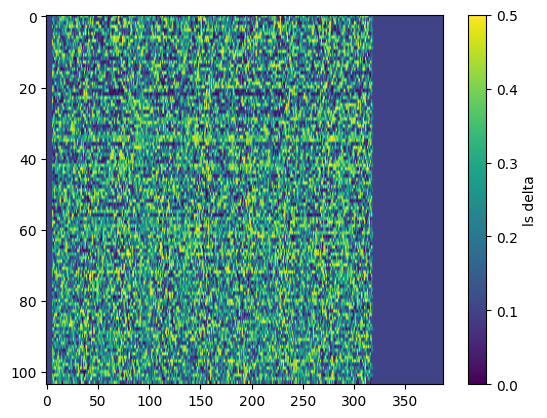

lomb scargle computation time for cluster 0 is 0.608928918838501, seconds
lomb scargle computation time for cluster 10 is 0.8227503299713135, seconds
lomb scargle computation time for cluster 1 is 0.7892439365386963, seconds
lomb scargle computation time for cluster 2 is 0.7894065380096436, seconds
lomb scargle computation time for cluster 3 is 0.7554950714111328, seconds
lomb scargle computation time for cluster 5 is 0.775644063949585, seconds
lomb scargle computation time for cluster 6 is 0.666663646697998, seconds
lomb scargle computation time for cluster 7 is 0.6643927097320557, seconds
lomb scargle computation time for cluster 4 is 0.9108786582946777, seconds
lomb scargle computation time for cluster 8 is 0.6719067096710205, seconds
lomb scargle computation time for cluster 19 is 0.6713135242462158, seconds
lomb scargle computation time for cluster 9 is 0.7294011116027832, seconds
lomb scargle computation time for cluster 11 is 0.677804708480835, seconds
lomb scargle computation t

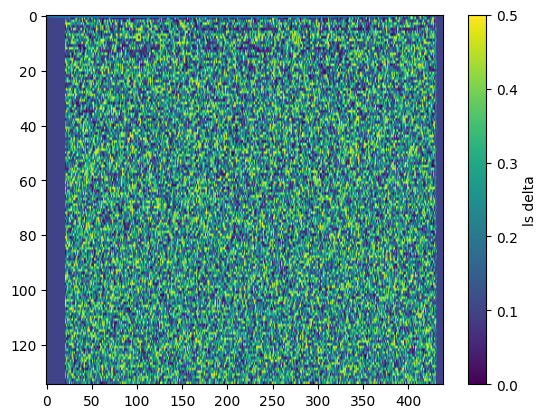

lomb scargle computation time for cluster 52 is 0.6179366111755371, seconds
lomb scargle computation time for cluster 70 is 0.6024563312530518, seconds
lomb scargle computation time for cluster 68 is 0.694725513458252, seconds
lomb scargle computation time for cluster 83 is 0.6227765083312988, seconds
lomb scargle computation time for cluster 84 is 0.6174073219299316, seconds
lomb scargle computation time for cluster 92 is 0.5949695110321045, seconds
lomb scargle computation time for cluster 96 is 0.6176126003265381, seconds
lomb scargle computation time for cluster 99 is 0.6088254451751709, seconds
lomb scargle computation time for cluster 94 is 0.7251207828521729, seconds
lomb scargle computation time for cluster 100 is 0.6108219623565674, seconds
lomb scargle computation time for cluster 102 is 0.6108217239379883, seconds
lomb scargle computation time for cluster 104 is 0.6267304420471191, seconds
lomb scargle computation time for cluster 105 is 0.6633739471435547, seconds
lomb scar

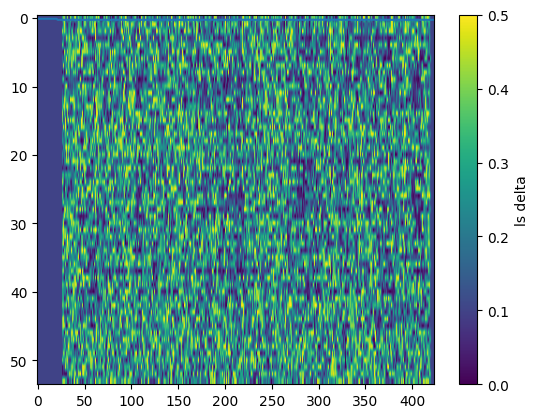

lomb scargle computation time for cluster 1 is 0.6437849998474121, seconds
lomb scargle computation time for cluster 0 is 0.7370259761810303, seconds
lomb scargle computation time for cluster 2 is 0.6492962837219238, seconds
lomb scargle computation time for cluster 3 is 0.6253714561462402, seconds
lomb scargle computation time for cluster 4 is 0.6606402397155762, seconds
lomb scargle computation time for cluster 7 is 0.6275970935821533, seconds
lomb scargle computation time for cluster 6 is 0.7481203079223633, seconds
lomb scargle computation time for cluster 10 is 0.661980152130127, seconds
lomb scargle computation time for cluster 12 is 0.6405763626098633, seconds
lomb scargle computation time for cluster 14 is 0.6137330532073975, seconds
lomb scargle computation time for cluster 15 is 0.6215047836303711, seconds
lomb scargle computation time for cluster 16 is 0.6667962074279785, seconds
lomb scargle computation time for cluster 17 is 0.6585042476654053, seconds
lomb scargle computa

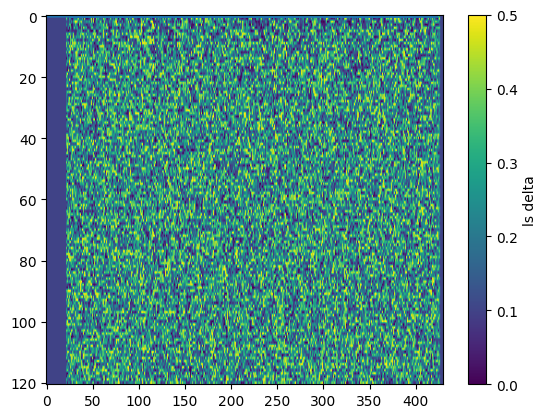

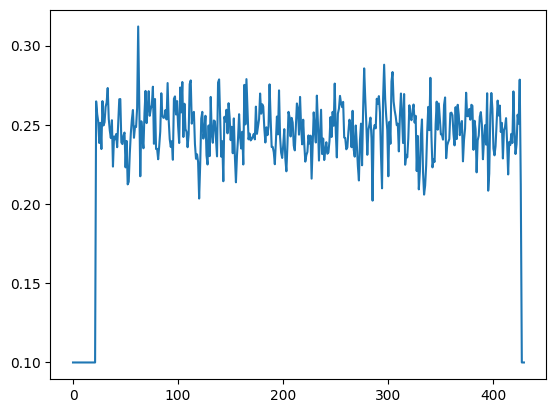

In [20]:
project_path = "/mnt/datastore/Harry/Cohort11_april2024/derivatives/"
# get sorting analyzer and unit locations
of_session_base_names = ["M20_D23_2024-05-25_14-10-43_OF1","M20_D24_2024-05-26_14-17-55_OF1","M20_D25_2024-05-27_13-57-19_OF1","M20_D26_2024-05-28_14-31-11_OF1"]
vr_session_base_names = ["M20_D23_2024-05-25_14-54-34_VR1","M20_D24_2024-05-26_14-49-32_VR1","M20_D25_2024-05-27_14-24-21_VR1","M20_D26_2024-05-28_15-18-55_VR1"]

for vr_name, of_name in zip(vr_session_base_names, of_session_base_names):
    mouse = vr_name.split("_")[0]
    day = vr_name.split("_")[1]
    sorting_analyzer_path = f"{project_path}{mouse}/{day}/ephys/sorting_analyzer"
    vr_path = f"{project_path}{mouse}/{day}/vr/{vr_name}/processed/kilosort4/spikes.pkl"
    ramp_path = f"{project_path}{mouse}/{day}/vr/{vr_name}/processed/kilosort4/ramp_classifications.pkl"
    of_path = f"{project_path}{mouse}/{day}/of/{of_name}/processed/kilosort4/spikes.pkl"
    position_path = f"{project_path}{mouse}/{day}/vr/{vr_name}/processed/position_data.csv"
    processed_position_path = f"{project_path}{mouse}/{day}/vr/{vr_name}/processed/processed_position_data.pkl"
    position_data = pd.read_csv(position_path)
    processed_position_data = pd.read_pickle(processed_position_path)
    spike_data_vr = pd.read_pickle(vr_path); spike_data_vr["firing_times_vr"] = spike_data_vr["firing_times"]; spike_data_vr["session_id_vr"] = vr_name
    spike_data_of = pd.read_pickle(of_path); spike_data_of["firing_times_of"] = spike_data_of["firing_times"]; spike_data_of["session_id_of"] = of_name
    ramp_data_vr = pd.read_pickle(ramp_path)
    ramp_data_vr = ramp_score(ramp_data_vr)
    spike_data = pd.merge(spike_data_vr, spike_data_of, on="cluster_id")
    spike_data = pd.merge(spike_data, ramp_data_vr, on="cluster_id")
    spike_data["firing_times"] = spike_data["firing_times_vr"]
    spike_data = spike_data[(spike_data["snr_x"] > 1) & (spike_data["mean_firing_rate_x"] > 0.5) & (spike_data["rp_contamination_x"] < 0.9)]

    if "ls_deltas" not in list(spike_data):
        spike_data = lomb_scargle_parallel(spike_data, processed_position_data, track_length=200, verbose=False)
        
    plot_network_anchor(spike_data=spike_data, position_data=position_data)

In [ ]:
len(filtered_df)

In [ ]:

data = pandas_collumn_to_2d_numpy_array(filtered_df["ls_deltas"])
print(np.shape(data))
# Create the heatmap
plt.imshow(data, cmap='viridis', aspect='auto')
plt.colorbar(label='Value')

# Add title and labels
plt.title('Heatmap of Values Between 0 and 0.5')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Display the heatmap
plt.show()
   